# Identication of putative contaminant taxa

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(foreach)
require(tidyverse)
require(ggplot2)
require(data.table)
require(compositions)
library(doParallel)
registerDoParallel(cores=8)

Loading required package: foreach

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: compos

### Data pre-processing functions

In [2]:
load_data <- function(file_path) {
    df <- as.data.frame(fread(file_path)) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


load_metadata <- function(file_path, df) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% df$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}


subset_metadata <- function(meta, n_subset) {
    meta <- as.data.frame(meta)
    cohorts <- unique(meta$site_supplying_sample)
    subset_vec <- c()

    for (i in cohorts) {
        ids <- meta$npm_research_id[meta$site_supplying_sample == i]
        
        if (length(ids) > n_subset) {
            subset_ids <- sample(ids, n_subset)
            subset_vec <- c(subset_vec, subset_ids)
        } else {
            subset_vec <- c(subset_vec, ids)
        }
    }

    meta_sub <- meta %>%
      filter(npm_research_id %in% subset_vec) 
    return(meta_sub)
}


retrieve_rows_from_meta <- function(df, meta) {
    return(df %>% filter(npm_research_id %in% meta$npm_research_id)) 
}


remove_cols <- function(df, col_to_exclude) {
    return(df %>% select(-all_of(col_to_exclude)))
}


remove_low_prev_taxa <- function(df, frac_presence) {
    n_original <- ncol(df[, colnames(df) != "npm_research_id"])
    PA_df <- apply(df[, 2:ncol(df)], 2, function(x) {ifelse(x > 0, T, F)})
    frac_df <- apply(PA_df, 2, function(x) {sum(x) / nrow(PA_df)})
    to_keep <- names(frac_df[frac_df > frac_presence])
    to_keep <- c("npm_research_id", to_keep)
    n_new <- length(to_keep) - 1
    print(str_glue("{n_new} / {n_original} taxa are present in {frac_presence} of samples"))
    return(df %>% select(all_of(to_keep)))
}


otu_to_RA <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, df$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


RA_to_clr <- function(df) {
    mat <- df_filt[, colnames(df_filt) != "npm_research_id"]
    clr_df <- clr(mat)
    return(cbind(data.frame(npm_research_id = df$npm_research_id), as.data.frame(clr_df, check.names = F)))
}


get_metadata_plots <- function(meta, meta_cols) {
    meta <- as.matrix(meta)
    meta <- as_tibble(meta, rownames = "sample")

    plots <- list()
    
    for (column in meta_cols) {
        plt <- meta %>%
            mutate(across(everything(), as.character)) %>%
            select(all_of(column)) %>%
            group_by_at(column) %>%
            summarise(n = n()) %>%
            ggplot(aes_string(x = column, y = "n", fill = column)) +
                geom_bar(stat = "identity") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                geom_text(aes_string(label = "n"))
        plots[[column]] <- plt
    }
    
    return(plots)
}


get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


print_group_freqs <- function(meta, meta_cols) {
    for (col in meta_cols) {
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())
        print(col)
        print(tmp)
    }
}


get_batch_prevalence <- function(x) {sum(x) / length(x)}


remove_low_read_samples <- function(df) {
    to_retain <- fread("data/samples_above_10_reads.txt")$npm_research_id
    return(df %>% filter(npm_research_id %in% to_retain))
}


remove_low_sample_levels <- function(dat, metadat, column, min_samples) {
    # Remove levels with < x samples
    tmp <- tibble(data.frame(metadat)) %>%
            group_by(get(column)) %>%
            summarise(n = n())

    # Vector of group levels to keep
    to_keep <- tmp[tmp$n >= min_samples, "get(column)"]$`get(column)`
    to_keep <- to_keep[to_keep != "Unknown"]
    n_levels <- length(to_keep)

    if (n_levels < 2) {
        print(str_glue("After pruning, {column} has < 2 levels"))
    } else {
        print(str_glue("After pruning, {column} has {n_levels} levels"))
    }

    # Remove rows in metadata
    metadat_filt <- metadat %>% filter(get(column) %in% to_keep)

    # Retrieve rows
    dat_filt <- retrieve_rows_from_meta(dat, metadat_filt)
    metadat_filt <- metadat_filt %>% filter(npm_research_id %in% dat_filt$npm_research_id)

    return(list(dat_filt = dat_filt, metadat_filt = metadat_filt))
}


remove_empty_rows <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    row_sums <- rowSums(mat)
    df_filt <- df[row_sums != 0, ]
    nrow(df_filt)

    n_original <- nrow(df)
    n_removed <- n_original - nrow(df_filt)
    
    print(str_glue("{n_removed}/{n_original} samples removed due to having no reads of interest"))
    
    return(df_filt)
}

#### Functions for testing differential abundance

In [18]:
get_diff_abn <- function(dat_filt, metadat_filt, taxon, column, lq_p = 0.25, hq_p = 0.75, fold_threshold = 0) {
    # Remove zeros in CLR values
    q_df <- dat_filt %>%
        left_join(metadat_filt, by = "npm_research_id") %>%
        select(all_of(c(taxon, column))) %>%
        filter(get(taxon) != 0) %>%
        group_by(get(column)) %>%
        summarise(lq = quantile(get(taxon), probs = lq_p),
                  hq = quantile(get(taxon), probs = hq_p))

    # Do pairwise comparisons between levels
    pairwise_results <- foreach(idx = seq(nrow(q_df))) %do% {
        level1 <- q_df[idx, ]$`get(column)`
        lowest_lq <- q_df[idx, ]$lq
        lowest_lq
        diff_df <- q_df %>% 
            mutate(diff_abn = hq + fold_threshold < lowest_lq) %>%
            rename("level2" = "get(column)")

        if(any(diff_df$diff_abn)) {
            res <- diff_df %>%
                filter(diff_abn == T) %>%
                mutate(taxa = taxon, meta_col = column, level1 = level1, .before = 1) %>%
                select(-diff_abn) %>% 
                rename(level1_lq = lq, level2_hq = hq)

            return(res)
        }
    }

    return(bind_rows(pairwise_results))
}


decontaminate_this_col <- function(dat, metadat, column, min_samples, lq_p, hq_p, fold_threshold) {
    data_list <- remove_low_sample_levels(dat, metadat, column, min_samples)
    metadat_filt <- data_list[["metadat_filt"]]
    dat_filt <- data_list[["dat_filt"]]
    taxa <- colnames(dat_filt %>% select(-npm_research_id))
    
    # Get differential abundance results for all taxa
    col_results <- foreach(taxon = taxa) %dopar% {
        taxon_results <- get_diff_abn(dat_filt, metadat_filt, taxon, column, lq_p = lq_p, hq_p = hq_p, fold_threshold = fold_threshold)
    }

    return(bind_rows(col_results))
}

## Main

In [60]:
min_samples <- 10
n_subset <- 9999
human <- "Homo sapiens"
rank <- "S"
n <- 9999
frac_presence <- 0.05
lq_p <- 0.10
hq_p <- 0.90
fold_threshold <- 0


to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id
df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>% 
    filter(npm_research_id %in% to_retain)
meta <- load_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", df)

# Get metadata subset
meta_filt <- subset_metadata(meta, n)
# Filter data
df_filt <- retrieve_rows_from_meta(df, meta_filt)
df_filt <- remove_cols(df_filt, c(human, "unclassified"))
df_filt <- remove_low_prev_taxa(df_filt, frac_presence = frac_presence)
df_filt <- otu_to_RA(df_filt)
df_filt <- RA_to_clr(df_filt)

# Get metadata columns of interest
meta_cols <- get_meta_cols(meta_filt)

# Decontaminate all columns
system.time({
    results <- foreach(column = meta_cols) %do% {
        col_res <- decontaminate_this_col(df_filt, meta_filt, column, 
                                          min_samples = min_samples, 
                                          lq_p = lq_p, 
                                          hq_p = hq_p, 
                                          fold_threshold = fold_threshold)
        return(col_res)
    }
})

stopImplicitCluster()

result_df <- bind_rows(results)
head(result_df)

1792 / 5199 taxa are present in 0.05 of samples
After pruning, site_supplying_sample has 6 levels
After pruning, extraction_kit has 6 levels
After pruning, instrument_id has 5 levels
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot has 33 levels
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot has 30 levels
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot has 27 levels
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot has 30 levels
After pruning, hiseq_xtm_flow_cell_v2_5_lot has 34 levels


    user   system  elapsed 
4645.172  199.937  621.141 

taxa,meta_col,level1,level2,level1_lq,level2_hq
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Ralstonia pickettii,site_supplying_sample,TTSH,GUSTO,-0.7530883,0.91237574
Bordetella genomosp. 13,site_supplying_sample,PRISM,GUSTO,-0.8393351,-0.02660418
Bordetella genomosp. 13,site_supplying_sample,PRISM,HELIOS,-0.9422720,0.44095662
Bordetella genomosp. 13,site_supplying_sample,PRISM,MEC,-1.1423158,0.59221692
Bordetella genomosp. 13,site_supplying_sample,PRISM,SERI,-0.7865872,0.33437071
Bordetella genomosp. 13,site_supplying_sample,PRISM,TTSH,-0.9299292,-0.27725648


In [61]:
n_contam <- length(unique(result_df$taxa))

all_species <- colnames(df_filt)[colnames(df_filt) != "npm_research_id"]
non_contaminants <- all_species[!(all_species %in% unique(col_res$taxa))]

nc_df <- tibble(non_contaminants = non_contaminants)
fwrite(nc_df, str_glue("results/decontamination/clr_decontamination/NC.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.txt"))
fwrite(result_df, str_glue("results/decontamination/clr_decontamination/results.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.csv"))

In [63]:
length(non_contaminants)

[1] 72

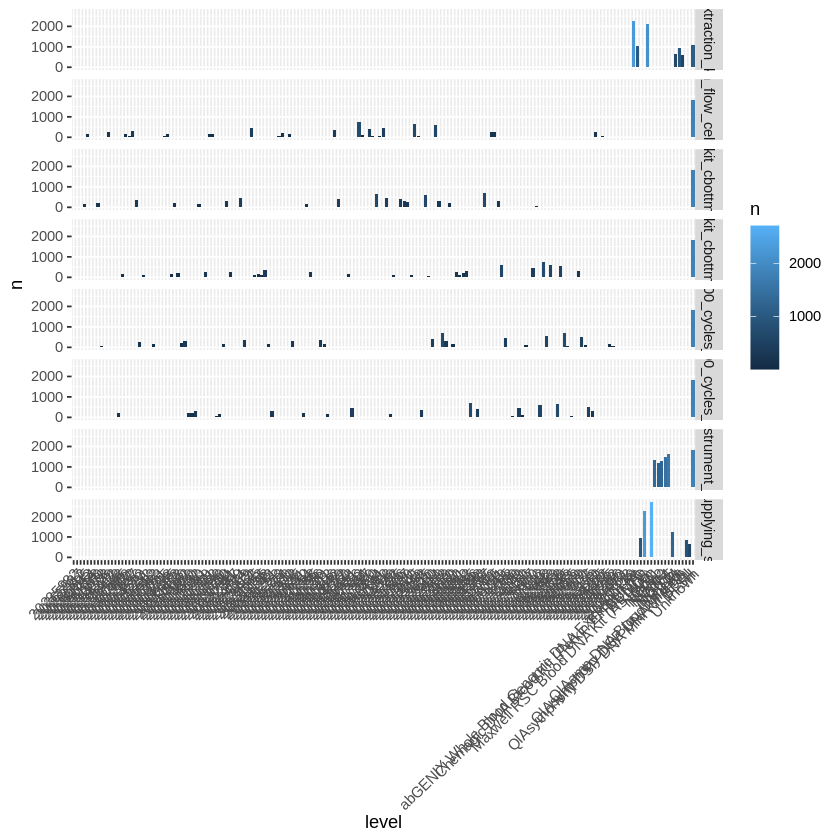

In [40]:
meta_filt %>%
    select(all_of(c("npm_research_id", meta_cols))) %>%
    pivot_longer(!npm_research_id, names_to = "meta_col", values_to = "level") %>%
    group_by(meta_col) %>%
    count(level) %>%
    ggplot(aes(x = level, y = n, fill = n)) +
        geom_bar(stat = "identity") +
        facet_grid(rows = vars(meta_col)) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggsave("results/metadata_barplot.pdf", dpi = 600, width = 20, height = 49)

In [ ]:
dawdawdawdawdd

In [ ]:
dat_filt %>% 
    left_join(metadat_filt) %>%
    filter(get(tax) != 0) %>%
    group_by(site_supplying_sample) %>%
    summarise(lq = quantile(get(tax), 0.25), hq = quantile(get(tax), 0.75))

In [ ]:
dat_filt %>% 
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "clr") %>%
    filter(clr != 0) %>%
    ggplot(aes(x = clr)) +
        geom_density()

Joining, by = "npm_research_id"



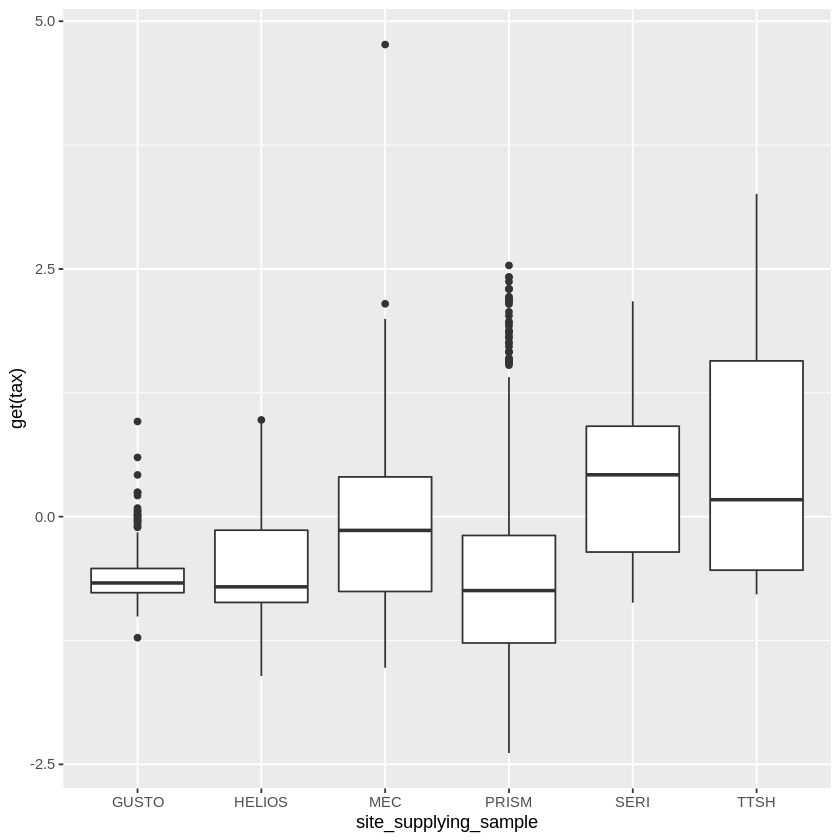

In [49]:
tax <- "Burkholderia stabilis"
df_filt %>% 
    left_join(meta_filt) %>%
    filter(get(tax) != 0) %>%
    ggplot(aes(y = get(tax), x = site_supplying_sample)) +
        geom_boxplot()

In [ ]:
result_df <- bind_rows(results)
result_df %>% distinct(taxa)

In [ ]:
metadat <- meta_filt
dat <- df_filt
taxon <- "Streptococcus oralis"
lq_p <- 0.25
hq_p <- 0.75
fold_threshold <- 0

In [ ]:
idx <- 1
    level1 <- q_df[idx, ]$`get(column)`
    lowest_lq <- q_df[idx, ]$lq
    lowest_lq
    diff_df <- q_df %>% 
        mutate(diff_abn = hq + fold_threshold < lowest_lq) %>%
        rename("level2" = "get(column)")

    if(any(diff_df$diff_abn)) {
        res <- diff_df %>%
            filter(diff_abn == T) %>%
            mutate(taxa = taxon, meta_col = column, level1 = level1, .before = 1) %>%
            select(-diff_abn) %>% 
            rename(level1_lq = lq, level2_hq = hq)

        return(res)
    }
        


#### Diff. prevalence decontamination procedure

In [ ]:
decontaminate <- function(rank, n_subset, n, human, read_threshold) {
    # Load data and remove low microbial read samples
    to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id
    df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>% 
        filter(npm_research_id %in% to_retain)
    meta <- load_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", df)
    
    # Get metadata subset
    meta_filt <- subset_metadata(meta, n)

    # Filter data
    df_filt <- retrieve_rows_from_meta(df, meta_filt)
    df_filt2 <- remove_cols(df_filt, c(human, "unclassified"))
    df_filt3 <- remove_low_prev_taxa(df_filt2, frac_presence = 0.05)
    df_filt4 <- remove_empty_rows(df_filt3)
    df_filt4 <- otu_to_RA(df_filt4)

    # Get metadata columns of interest
    meta_cols <- get_meta_cols(meta_filt)
    
#     # Print group freqs
#     print_group_freqs(meta_filt, meta_cols)
    
    # Differential prevalence
    res <- run_diff_prev(df_filt4, meta_filt, meta_cols, read_threshold = read_threshold, prev_threshold = 2 , min_samples = 5)
    
    return(res)
}


parse_decontamination_results <- function(decontam_res) {
    non_contaminants <- decontam_res %>%     
        group_by(taxa) %>%
        summarise(n_diff = sum(diff_prev)) %>%
        filter(n_diff == 0)
    non_contaminants <- non_contaminants$taxa

    contaminants <- decontam_res %>%
        group_by(taxa) %>%
        summarise(n_diff = sum(diff_prev)) %>%
        filter(n_diff > 0)
    contaminants <- contaminants$taxa
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}


#### Rarefy decontamination procedure

In [7]:
# rarefy_decontaminate <- function(rank, human, breaks) {
#     morsels <- foreach (n = breaks) %do% {
#         res <- decontaminate(rank, 9999, n, human, 0.001)
#         res_list <- parse_decontamination_results(res)
#         morsel <- tibble(non_contaminants = res_list[["non_contaminants"]], n = n)
#         return(morsel)
#     }

#     nc_df <- bind_rows(morsels)
#     return(nc_df)
# }

#### Visualise

In [8]:
# diff_prev_heatmap <- function(nc) {
#     plt <- nc %>% 
#         mutate(n = as.factor(n)) %>%
#         ggplot(aes(x = n, y = non_contaminants)) +
#         geom_tile(color = "black") +
#         scale_x_discrete(breaks = breaks) +
#         theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
#         labs(x = "No. of samples", y = "Non-contaminant taxa")

#         return(plt)
# }

### Main for diff. prevalence decontamination

In [9]:
# breaks <- c(100, 200, 400, 800, seq(1000, 9000, 1000), 9999)
# # breaks <- c(100, 200, 400)
# # breaks <- c(9999)
# breaks

# species_nc_df <- rarefy_decontaminate("S", "Homo sapiens", breaks)
# genus_nc_df <- rarefy_decontaminate("G", "Homo", breaks)

In [10]:
# diff_prev_heatmap(species_nc_df)
# ggsave("results/decontamination/non_contaminant_species_heatmap.png", dpi = 300, width = 5, height = 10)

In [11]:
# diff_prev_heatmap(genus_nc_df)
# ggsave("results/decontamination/non_contaminant_genus_heatmap.png", dpi = 300, width = 5, height = 10)

In [12]:
full_genus_df <- decontaminate("G", 9999, 9999, "Homo", 0.001)
full_genus_res <- parse_decontamination_results(full_genus_df)
fwrite(full_genus_df, str_glue("results/decontamination/diff_prev_raw/diff_prev_results.9999.G.RA.csv"))

full_species_df <- decontaminate("S", 9999, 9999, "Homo sapiens", 0.001)
full_species_res <- parse_decontamination_results(full_species_df)
fwrite(full_species_df, str_glue("results/decontamination/diff_prev_raw/diff_prev_results.9999.S.RA.csv"))

fwrite(tibble(non_contaminants = full_genus_res[["non_contaminants"]]), str_glue("results/decontamination/prevalence.noncontam.G.n9999.RA.txt"))
fwrite(tibble(contaminants = full_genus_res[["contaminants"]]), str_glue("results/decontamination/prevalence.contam.G.n9999.RA.txt"))

fwrite(tibble(non_contaminants = full_species_res[["non_contaminants"]]), str_glue("results/decontamination/prevalence.noncontam.S.n9999.RA.txt"))
fwrite(tibble(contaminants = full_species_res[["contaminants"]]), str_glue("results/decontamination/prevalence.contam.S.n9999.RA.txt"))


612 / 1492 taxa are present in 0.05 of samples
0/8728 samples removed due to having no reads of interest
[1] "site_supplying_sample"
After pruning, site_supplying_sample has 6 levels
[1] "extraction_kit"
After pruning, extraction_kit has 6 levels
[1] "instrument_id"
After pruning, instrument_id has 5 levels
[1] "hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot"
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot has 33 levels
[1] "hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot"
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot has 33 levels
[1] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot"
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot has 28 levels
[1] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot"
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot has 32 levels
[1] "hiseq_xtm_flow_cell_v2_5_lot"
After pruning, hiseq_xtm_flow_cell_v2_5_lot has 35 levels
1792 / 5199 taxa are present in 0.05 of samples
0/8728 s

### Correlation filter

In [13]:
load_parse_RA <- function(n_subset, rank, human) {
    # Load data
    to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id
    df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>% 
        filter(npm_research_id %in% to_retain)
    meta <- load_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", df)
    
    # Get metadata subset
    meta_filt <- subset_metadata(meta, 9999)

    # Filter data
    df_filt <- retrieve_rows_from_meta(df, meta_filt)
    df_filt2 <- remove_cols(df_filt, c(human, "unclassified"))
    df_filt3 <- remove_low_freq_taxa(df_filt2, frac_presence = 0.05)
    df_filt4 <- remove_empty_rows(df_filt3)
    print(ncol(df_filt4))
    RA_df <- otu_to_RA(df_filt4)
    
    return(RA_df)
}

In [14]:
corr_decontam <- function(RA_df, non_contaminants, contaminants) {
    nc_list <- foreach (non_contaminant_taxon = non_contaminants) %do% {
        morsel <- tibble()
        for (contaminant_taxon in contaminants) {
            spearman_test <- cor.test(RA_df[ ,contaminant_taxon], RA_df[, non_contaminant_taxon])
            rho <- spearman_test$estimate
#             p_val <- spearman_test$p.value
#             p_adj <- p.adjust(p_val, method = "BH", n = length(length(non_contaminants) * length(contaminants)))
    #         print(str_glue("{non_contaminant_taxon} has correlation of {rho} with {contaminant_taxon}, p = {p_adj}"))
            morsel <- morsel %>% bind_rows(tibble(non_contaminant_taxon = non_contaminant_taxon, 
                                           contaminant_taxon = contaminant_taxon,
                                           rho = rho))
        }

        return(morsel)
    }

    corr_df <- bind_rows(nc_list)  
    return(corr_df)
}

In [15]:
species_RA <- load_parse_RA(9999, "S", "Homo sapiens")
genus_RA <- load_parse_RA(9999, "G", "Homo")

1792 / 5199 taxa are present in 0.05 of samples
0/8728 samples removed due to having no reads of interest
[1] 1793
612 / 1492 taxa are present in 0.05 of samples
0/8728 samples removed due to having no reads of interest
[1] 613


In [16]:
genus_c <- full_genus_res[["contaminants"]]
genus_nc <- full_genus_res[["non_contaminants"]]

species_c <- full_species_res[["contaminants"]]
species_nc <- full_species_res[["non_contaminants"]]

species_corr <- corr_decontam(species_RA, species_nc, species_c)
genus_corr <- corr_decontam(genus_RA, genus_nc, genus_c)

In [17]:
genus_n_nc <- length(genus_nc)
species_n_nc <- length(species_nc)

print(str_glue("{genus_n_nc}/{ncol(genus_RA)} genus after differential prevalence decontamination"))
print(str_glue("{species_n_nc}/{ncol(species_RA)} species after differential prevalence decontamination"))

1/613 genus after differential prevalence decontamination
0/1793 species after differential prevalence decontamination


#### Visualise number of taxa retained by correlation threshold

In [18]:
get_corr_dist <- function(corr_df, non_contaminants) {
    rho_df <- tibble()
    for (i in seq(0, 1, 0.05)) {
        filtered_corr <- corr_df %>% 
            filter(rho > i)

        n_retained <- length(non_contaminants) - length(unique(filtered_corr$non_contaminant_taxon))
        morsel <- tibble(rho = i, n_retained = n_retained)
        rho_df <- rho_df %>% bind_rows(morsel)
    }
    
    rho_plt <- rho_df %>%
        ggplot(aes(x = rho, y = n_retained)) +
        geom_point() +
        labs(y = "No. of taxa retained", x = "Rho threshold")
    print(rho_plt)
    return(rho_df)
}

rho,n_retained
<dbl>,<int>
0.00,0
0.05,0
0.10,0
0.15,0
0.20,0
0.25,0
0.30,0
0.35,0
0.40,0


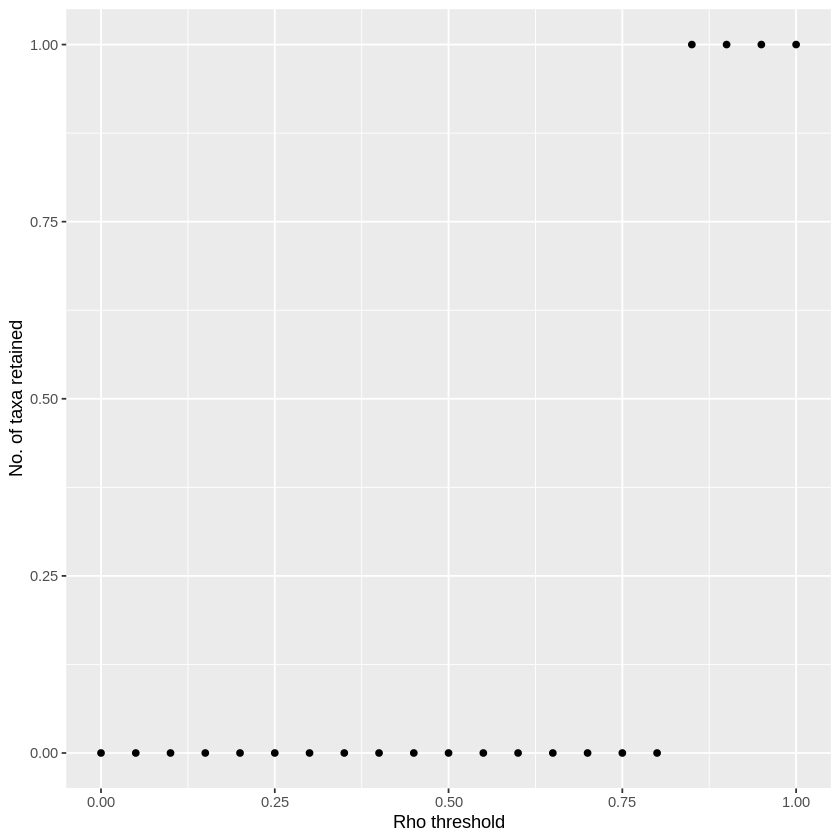

In [19]:
genus_corr_dist <- get_corr_dist(genus_corr, genus_nc)
genus_corr_dist

# ggsave("results/decontamination/genus_rho_threshold_plot.png", dpi = 300)

In [20]:
species_corr_dist <- get_corr_dist(species_corr, species_nc)
species_corr_dist

# ggsave("results/decontamination/species_rho_threshold_plot.png", dpi = 300)

ERROR: Error: Problem with `filter()` input `..1`.
[34mℹ[39m Input `..1` is `rho > i`.
[31m✖[39m object 'rho' not found


#### Save contaminant and non-contaminant taxa

In [ ]:
get_filtered_taxa <- function(corr_df, nc, corr_t) {
    to_remove <- corr_df %>% 
        filter(rho > corr_t) %>%
        distinct(non_contaminant_taxon) %>%
        rename(to_remove = non_contaminant_taxon)
    to_keep <- tibble(non_contaminants = nc) %>% 
        filter(!(non_contaminants %in% to_remove$to_remove))
    return(list(to_remove = to_remove, to_keep = to_keep))
}

In [ ]:
corr_t <- 0.7
species_corr_res <- get_filtered_taxa(species_corr, species_nc, corr_t)
genus_corr_res <- get_filtered_taxa(genus_corr, genus_nc, corr_t)

species_corr_res
genus_corr_res

In [ ]:
fwrite(species_corr_res[["to_keep"]], 
       str_glue("results/decontamination/prevalence.corr.noncontam.S.n9999.RA.txt"))
fwrite(species_corr_res[["to_remove"]], 
       str_glue("results/decontamination/prevalence.corr.contam.S.n9999.RA.txt"))

fwrite(genus_corr_res[["to_keep"]], 
       str_glue("results/decontamination/prevalence.corr.noncontam.G.n9999.RA.txt"))
fwrite(genus_corr_res[["to_remove"]], 
       str_glue("results/decontamination/prevalence.corr.contam.G.n9999.RA.txt"))

In [ ]:
genus_corr_res[["to_keep"]]
species_corr_res[["to_keep"]]

### Identify RA thresholds

In [29]:
long_RA <- species_RA %>%
    pivot_longer(!npm_research_id, names_to = "taxon", values_to = "rel_a") 

In [35]:
seq(5, 100, 5)

[1]   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95
[20] 100

#### RA thresholds ~ percentile

In [63]:
quantiles <- foreach (perc = seq(73, 100, 0.5)) %do% {
    quant <- quantile(long_RA$rel_a, perc / 100)
    return(tibble(perc = perc, quant = quant))
}

q_df <- bind_rows(quantiles)

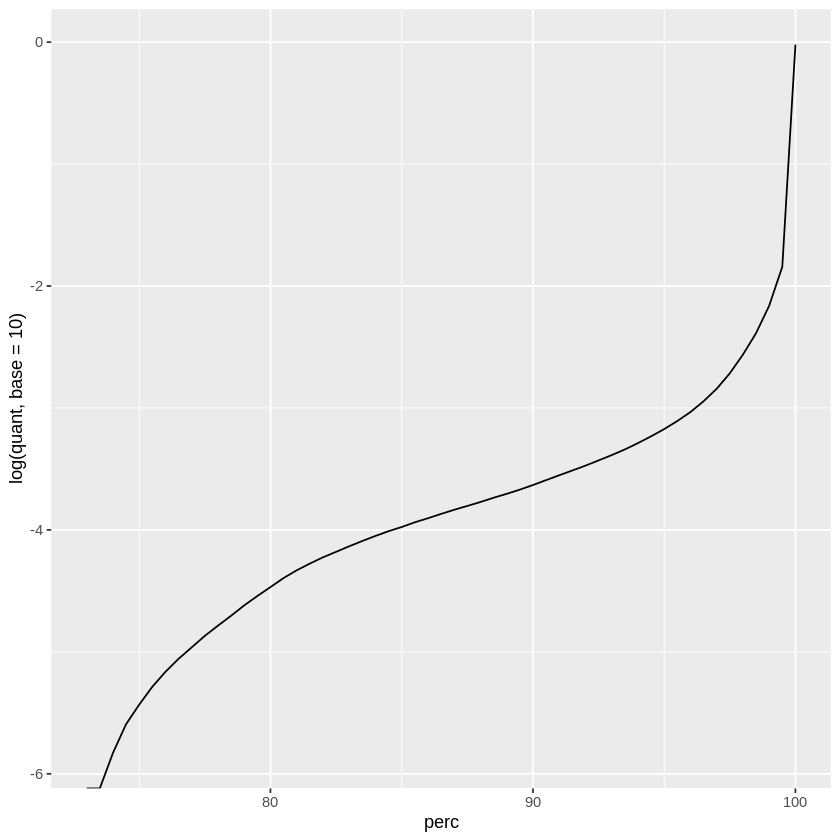

In [67]:
q_df %>%
    ggplot(aes(x = perc, y = log(quant, base = 10))) +
    geom_line()

In [74]:
length(full_genus_res[["non_contaminants"]])

[1] 1

In [81]:
threshold_df <- tibble()
for (perc in seq(73, 100, 0.5)) {
    read_threshold <- quantile(long_RA$rel_a, perc / 100)
    full_species_df <- decontaminate("S", 9999, 9999, "Homo sapiens", read_threshold = read_threshold)
    full_species_res <- parse_decontamination_results(full_species_df)
    fwrite(full_species_df, str_glue("results/decontamination/RA_thresholds/diff_prev_results.9999.S.RA.perc_{read_threshold}.csv"))
    fwrite(tibble(non_contaminants = full_species_res[["non_contaminants"]]), str_glue("results/decontamination/RA_thresholds/prevalence.noncontam.S.n9999.RA.perc_{read_threshold}.txt"))
    threshold_df <- threshold_df %>% bind_rows(tibble(perc = perc, read_threshold = read_threshold, n_nc = length(full_species_res[["non_contaminants"]])))
}

1792 / 5199 taxa are present in 0.05 of samples
0/8728 samples removed due to having no reads of interest
[1] "site_supplying_sample"
After pruning, site_supplying_sample has 6 levels
[1] "extraction_kit"
After pruning, extraction_kit has 6 levels
[1] "instrument_id"
After pruning, instrument_id has 5 levels
[1] "hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot"
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot has 33 levels
[1] "hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot"
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot has 33 levels
[1] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot"
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot has 28 levels
[1] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot"
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot has 32 levels
[1] "hiseq_xtm_flow_cell_v2_5_lot"
After pruning, hiseq_xtm_flow_cell_v2_5_lot has 35 levels
1792 / 5199 taxa are present in 0.05 of samples
0/8728 

In [82]:
threshold_df

perc,read_threshold,n_nc
<dbl>,<dbl>,<int>
73.0,0.000000e+00,1792
73.5,0.000000e+00,1792
74.0,1.482048e-06,1
74.5,2.553409e-06,1
75.0,3.691610e-06,1
75.5,5.176278e-06,1
76.0,6.864384e-06,1
76.5,8.777512e-06,0
77.0,1.089159e-05,0


In [83]:
threshold_df <- tibble()
for (read_threshold in c(0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5)) {
    full_species_df <- decontaminate("S", 9999, 9999, "Homo sapiens", read_threshold = read_threshold)
    full_species_res <- parse_decontamination_results(full_species_df)
    fwrite(full_species_df, str_glue("results/decontamination/RA_thresholds/diff_prev_results.9999.S.RA.perc_{read_threshold}.csv"))
    fwrite(tibble(non_contaminants = full_species_res[["non_contaminants"]]), str_glue("results/decontamination/RA_thresholds/prevalence.noncontam.S.n9999.RA.perc_{read_threshold}.txt"))
    threshold_df <- threshold_df %>% bind_rows(tibble(read_threshold = read_threshold, n_nc = length(full_species_res[["non_contaminants"]])))
}

1792 / 5199 taxa are present in 0.05 of samples
0/8728 samples removed due to having no reads of interest
[1] "site_supplying_sample"
After pruning, site_supplying_sample has 6 levels
[1] "extraction_kit"
After pruning, extraction_kit has 6 levels
[1] "instrument_id"
After pruning, instrument_id has 5 levels
[1] "hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot"
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot has 33 levels
[1] "hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot"
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot has 33 levels
[1] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot"
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot has 28 levels
[1] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot"
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot has 32 levels
[1] "hiseq_xtm_flow_cell_v2_5_lot"
After pruning, hiseq_xtm_flow_cell_v2_5_lot has 35 levels
1792 / 5199 taxa are present in 0.05 of samples
0/8728 

In [84]:
threshold_df

read_threshold,n_nc
<dbl>,<int>
0.05,0
0.10,0
0.15,0
0.20,0
0.25,0
0.30,0
0.35,0
0.40,0
0.50,0
